In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=919ebc866dc0eab759f394b017e0aa4f83788cdb5c5a9a8645e6216de794b3d7
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import isnan, when, count, col, lit
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder

In [ ]:
sc = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data= sc.read.csv("/content/drive/My Drive/Colab Notebooks/Dataset/data.csv", inferSchema=True, header=True)

In [ ]:
data.printSchema()

root
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Engine Fuel Type: string (nullable = true)
 |-- Engine HP: integer (nullable = true)
 |-- Engine Cylinders: integer (nullable = true)
 |-- Transmission Type: string (nullable = true)
 |-- Driven_Wheels: string (nullable = true)
 |-- Number of Doors: integer (nullable = true)
 |-- Market Category: string (nullable = true)
 |-- Vehicle Size: string (nullable = true)
 |-- Vehicle Style: string (nullable = true)
 |-- highway MPG: integer (nullable = true)
 |-- city mpg: integer (nullable = true)
 |-- Popularity: integer (nullable = true)
 |-- MSRP: integer (nullable = true)



#Data cleaning
#We can describe the dataset to get the basic statistics of each column. Like the mean engine, horsepower is 249 while the standard deviation in highway mpg is 8.86.

#data.describe().toPandas().transpose()
#The main aspects of data cleaning require counting the total number of null values and removing columns with a high count of null values. The rows with high null values should also be removed.

#Certain missing values are entered as strings as “N/A”. These “N/A” strings are not recognized as missing values by Spark. So we need to replace “N/A” strings with None values. The below code replaces “None” If the column value matches the unrequired string. This will be termed by Spark as missing values. It can be concluded that the column Market Category contains 30% of the total values as null values. Now we can drop it and delete all row-wise null values.

In [ ]:
def replace(column, value):
    return when(column != value, column).otherwise(lit(None))
data = data.withColumn("Market Category", replace(col("Market Category"), "N/A"))
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()
data = data.drop("Market Category")
data = data.na.drop()
print((data.count(), len(data.columns)))

+----+-----+----+----------------+---------+----------------+-----------------+-------------+---------------+---------------+------------+-------------+-----------+--------+----------+----+
|Make|Model|Year|Engine Fuel Type|Engine HP|Engine Cylinders|Transmission Type|Driven_Wheels|Number of Doors|Market Category|Vehicle Size|Vehicle Style|highway MPG|city mpg|Popularity|MSRP|
+----+-----+----+----------------+---------+----------------+-----------------+-------------+---------------+---------------+------------+-------------+-----------+--------+----------+----+
|   0|    0|   0|               3|       69|              30|                0|            0|              6|           3742|           0|            0|          0|       0|         0|   0|
+----+-----+----+----------------+---------+----------------+-----------------+-------------+---------------+---------------+------------+-------------+-----------+--------+----------+----+

(11812, 15)


#Creating a Random Forest pipeline

#A machine learning pipeline integrates multiple sequential execution steps. It is used to streamline the machine learning process and automate the workflow.


#It prevents us from the task of executing each step individually. This pipeline can be saved and shared. We can load this pipeline again whenever required.

#VectorAssembler() function allows us to create a vector of features, by taking two parameters into consideration- Input columns and output column. The input columns form a single vector which would be stored in the output column.

In [ ]:
assembler = VectorAssembler(inputCols=["Year",
                                      "Engine HP",
                                      "Engine Cylinders",
                                      "Number of Doors",
                                      "highway MPG",
                                      "city mpg",
                                      "Popularity"], outputCol = "Attributes")

#Create a RandomForestRegressor with a feature column as “Attributes” and the label column as “MSRP”.

In [ ]:
regressor = RandomForestRegressor(featuresCol = "Attributes", labelCol="MSRP")
pipeline = Pipeline(stages=[assembler, regressor])

#Finally, we can save this pipeline on our Google Colab machine.


In [ ]:
pipeline.write().overwrite().save("pipeline")

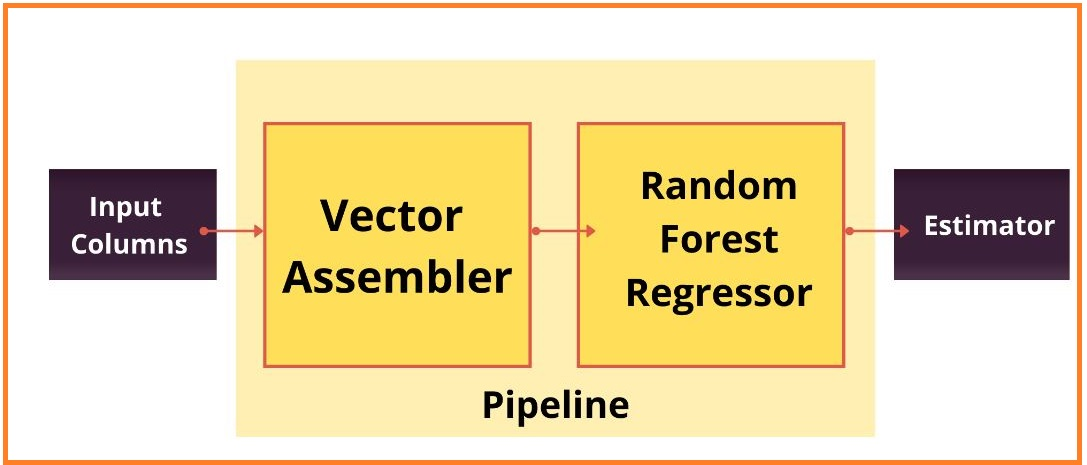

#Creating a cross validator for hyperparameter tuning

#Hyperparameter tuning is an essential step for creating an optimized machine learning model as it chooses the best parameters needed for the model.

#Cross-validation is a resampling procedure that is used to evaluate machine learning models. It ensures an unbiased model.

#Let’s begin by loading the previously created pipeline and create a grid map of parameters that we wish to explore for the random forest model. We can specify the parameter numTrees and give it a list of two values: 100 and 500.

In [13]:
pipelineModel = Pipeline.load("pipeline")
paramGrid = ParamGridBuilder().addGrid(regressor.numTrees, [100, 500]).build()

#Moving on to creating a cross-validator object. Usually, the cross-validator splits the training data into 10 folds and uses nine parts for training and the remaining one part for testing. Based on that, the models are evaluated.


#Then the process is continued by taking into account a different set of nine parts. It then loops over the hyperparameter and helps us to select the best parameters for the model.

#Here we can specify the number of folds as three. As we are using a regression evaluator, the evaluator metric is RMSE by default.

In [14]:
crossval = CrossValidator(estimator=pipelineModel,
estimatorParamMaps = paramGrid,
evaluator= RegressionEvaluator(labelCol = "MSRP"),
                               numFolds=3)

#Training and prediction

#Our first requirement is to split the data set into 80 % training and 20 % test set.

In [15]:
train_data, test_data = data.randomSplit([0.8,0.2], seed=123)

$Here, we come across one of the most important steps of —

#Passing training set to the vector assembler

#Passing its result to the Random Forest regressor.

#The training set is split into three parts due to the number of folds specified, and two distinct values for the number of trees in the Random Forest model are used. Finally, two models are created and evaluated based on RMSE. They are stored in the object cvModel

In [16]:
cvModel= crossval.fit(train_data)

#Try and extract the best model for prediction. For further clarity, we can view all the stages of the pipeline that the data went through.

In [17]:
bestModel= cvModel.bestModel
for x in range(len(bestModel.stages)):
    print(bestModel.stages[x])

VectorAssembler_8c9f24e7a09d
RandomForestRegressionModel: uid=RandomForestRegressor_66a158751b63, numTrees=500, numFeatures=7


#Lastly, predict the prices of the cars in the test set. Before that transform or predict the test set by using the cvModel object as it will automatically pick the best model.

In [18]:
pred = cvModel.transform(test_data)
pred.select("MSRP", "prediction").show()

+-----+------------------+
| MSRP|        prediction|
+-----+------------------+
|28030|32300.329676364916|
|30550| 38253.25157562784|
|29350| 28010.91458126463|
|27900|27282.442132143624|
|34890|27282.442132143624|
|32990|27282.442132143624|
| 2827|5162.8668842548595|
| 3000|5162.8668842548595|
| 3086| 5354.479230814443|
| 3130| 5354.479230814443|
| 3012| 5185.870312024985|
| 3622| 6247.527380561059|
|22300|24466.227463957286|
|19400|22582.824898834657|
| 2042| 5473.632155023948|
| 2144| 5465.558988691452|
|49440| 39663.10712743407|
|52640| 39663.10712743407|
|47440| 39815.96711355551|
|58400| 39746.51820908012|
+-----+------------------+
only showing top 20 rows



#Evaluating model’s performance
#We will use various metrics such as-

#Mean Squared Error (MSE)
#Root Mean Squared Error (RMSE)
#Mean Absolute Error (MAE)
#R squared (R2)

#These metrics indicate the performance of the model. According to these metrics, we can choose to rebuild the model according to our requirements.

#As we are aware that the regression evaluator’s default metric is RMSE so we can directly get the RMSE value of the predictions using the evaluate function, We can also evaluate using other metrics by changing the default metric bypassing the new metric to the evaluate function and interpret the output accordingly

In [20]:
eval = RegressionEvaluator(labelCol = "MSRP")
rmse = eval.evaluate(pred)
mse= eval.evaluate(pred, {eval.metricName: "mse"})
mae= eval.evaluate(pred, {eval.metricName: "mae"})
r2 = eval.evaluate(pred, {eval.metricName: "r2"})

#Inspect the metrics for model evaluation. The mean absolute error shows the average error, whether positive or negative. The R squared metric represents the variance in the training data captured by the model.

In [22]:
print("RMSE: %.3f" %rmse)
print("MSE: %.3f" %mse)
print("MAE: %.3f" %mae)
print("r2: %.3f" %r2)

RMSE: 35743.230
MSE: 1277578476.429
MAE: 9690.217
r2: 0.785
